In [1]:
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()
from ultron.factor.genetic.geneticist.operators import *

In [2]:
from kdutils.common import fetch_temp_data, fetch_temp_returns

In [3]:
method = 'aicso0'
instruments = 'ims'
period = 15

In [19]:
factprs_data = pd.read_feather("./records/ic/aicso0/ims/evolution/nxt1_ret_15h/programs_200036.feather")#[['formual','final_fitness','raw_fitness']]
factprs_data.head(10)

,name,method,gen,features,formual,final_fitness,raw_fitness,max_corr,penalty,alpha,update_time
0,ultron_1757853019743312,Point Mutation,1,f8d8e82d16b2ec02c5a025b9bfcd3e6e,"MKURT(8,MVARIANCE(12,'tv007_5_10_1'))",0.164144,0.164144,0,0,0,2025-09-14 12:30:18.871654
1,ultron_1757852618818388,Gen,0,77015239ec990a570f4e480be9c8c56b,"MSUM(18,MCPS(16,MPWMA(14,'cr003_10_15_1','ixy0...",0.099629,0.099629,0,0,0,2025-09-14 12:23:38.409188
2,ultron_1757852270479136,Subtree Mutation,1,e5883574345ba4fc4f77ee4042825cb6,CEIL('tc019_5_10_0'),0.097868,0.097868,0,0,0,2025-09-14 12:17:49.739567
3,ultron_1757853204610903,Gen,0,429c676964d9a8226482146f966652c7,"MDEMA(4,'tn002_5_0')",0.097381,0.097381,0,0,0,2025-09-14 12:33:23.805444
4,ultron_1757853733712345,Hoist Mutation,2,ee39117360f456dc083b0c2b2d438eac,AVG('tc012_10_10_15_1'),0.096779,0.096779,0,0,0,2025-09-14 12:42:13.356172


In [20]:
total_factors = fetch_temp_data(method=method,
                                    instruments=instruments,
                                    datasets=['train', 'val', 'test'])

total_returns = fetch_temp_returns(method=method,
                                       instruments=instruments,
                                       datasets=['train', 'val', 'test'],
                                       category='returns')
total_data = total_factors.merge(total_returns, on=['trade_time', 'code'])
nxt1_columns = total_data.filter(regex="^nxt1").columns.to_list()
basic_columns = [
        'close', 'high', 'low', 'open', 'value', 'volume', 'openint'
    ]
factor_columns = [
        col for col in total_data.columns
        if col not in ['trade_time', 'code'] + nxt1_columns + basic_columns
    ]
return_name = "nxt1_ret_{}h".format(period)

./records/aicso0/ims/basic/train_data.feather
./records/aicso0/ims/basic/val_data.feather
./records/aicso0/ims/basic/test_data.feather
./records/aicso0/ims/returns/train_returns.feather
./records/aicso0/ims/returns/val_returns.feather
./records/aicso0/ims/returns/test_returns.feather


In [21]:
### 聚合处理 K线数据
aggregation_rules = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'value': 'sum',
        'volume': 'sum',  # 成交量是流量，用 'sum'
        'openint': 'last'  # 持仓量是存量，用 'last'
    }
market_data = total_data[['trade_time', 'code'] + basic_columns]
market_data_indexed = market_data.set_index('trade_time')
agg_market_data = market_data_indexed.resample(
        '{0}T'.format(period), label='right',
        closed='right').agg(aggregation_rules)
    ###使用原始因子
factors_data = total_data[['trade_time', 'code'] + factor_columns].merge(
        agg_market_data.reset_index(),
        on=['trade_time'
            ]).merge(total_returns[['trade_time', 'code', return_name]],
                     on=['trade_time', 'code'])
factors_data.rename(columns={return_name: 'nxt1_ret'}, inplace=True)
factors_data

,trade_time,code,fz002_10_15_0,fz002_10_15_1,fz002_5_10_0,fz002_5_10_1,gd002_10_15_0,gd002_10_15_1,gd002_5_10_0,gd002_5_10_1,...,time_weight,equal_weight,open,high,low,close,volume,value,openint,nxt1_ret
0,2022-07-25 09:30:00,IM,0.000005,0.000012,1.510336e-07,1.071808e-05,0.514307,0.535732,0.638363,0.594229,...,0.000460,0.000614,6974.200000,6974.200000,6974.200000,6974.200000,56.0,7.811104e+07,17477.0,0.002429
1,2022-07-25 09:45:00,IM,0.000049,0.000055,4.717410e-05,6.529390e-05,0.180066,0.272906,0.288247,0.322786,...,-0.001219,-0.001388,6971.800000,7015.800000,6964.400000,7001.800000,3700.0,5.175727e+09,16483.0,-0.006898
2,2022-07-25 10:00:00,IM,-0.000003,-0.000022,-7.018672e-06,-4.063296e-05,0.661152,0.591422,0.715529,0.652066,...,0.000636,0.000752,7001.800000,7004.600000,6944.000000,6955.000000,2404.0,3.351038e+09,16046.0,0.000903
3,2022-07-25 10:15:00,IM,0.000001,-0.000007,8.124488e-06,1.705569e-07,0.441229,0.526559,0.493986,0.577656,...,-0.001203,-0.001510,6955.200000,6978.200000,6944.400000,6953.600000,1167.0,1.624664e+09,15882.0,0.001209
4,2022-07-25 10:30:00,IM,0.000010,0.000021,3.856284e-05,4.335823e-05,0.515261,0.481196,0.388365,0.485774,...,-0.000005,-0.000007,6953.600000,6973.600000,6938.000000,6971.800000,1065.0,1.481669e+09,15702.0,-0.001141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10858,2025-03-14 14:00:00,IM,0.000016,0.000034,2.165908e-05,3.850843e-05,0.418694,0.406919,0.390024,0.368659,...,-0.000279,-0.000310,7875.086509,7906.651430,7875.086509,7902.073312,8084.0,1.059437e+10,144006.0,-0.001843
10859,2025-03-14 14:15:00,IM,0.000006,0.000010,-6.968535e-07,5.931466e-07,0.486146,0.537065,0.632863,0.618389,...,0.000159,0.000300,7901.832358,7906.169523,7874.604602,7885.688467,8598.0,1.126435e+10,145107.0,0.000721
10860,2025-03-14 14:30:00,IM,0.000008,0.000017,2.651560e-05,3.390304e-05,0.445954,0.429096,0.380556,0.412644,...,0.000096,0.000120,7885.688467,7905.687616,7880.628442,7889.543725,6047.0,7.922936e+09,146345.0,-0.000641
10861,2025-03-14 14:45:00,IM,0.000005,0.000011,8.755982e-06,1.938355e-05,0.462228,0.468820,0.535058,0.467330,...,-0.000145,-0.000127,7890.025632,7901.109498,7878.700813,7889.543725,6211.0,8.135414e+09,147384.0,0.002111


In [22]:
total_data1 = factors_data.set_index('trade_time')

In [23]:
##
expression = "MDEMA(4,'tn002_5_0')"

In [24]:
factor_data = calc_factor(expression=expression,
                                  total_data=total_data1,
                                  indexs=[],
                                  key='code')
factor_data.head()

,transformed,code
trade_time,,
2022-07-25 09:30:00,426.165286,IM
2022-07-25 09:45:00,665.139582,IM
2022-07-25 10:00:00,762.105580,IM
2022-07-25 10:15:00,761.315913,IM
2022-07-25 10:30:00,696.497887,IM


In [10]:
backup_cycle =  1
factor_data = factor_data.replace([np.inf, -np.inf], np.nan)
factor_data['transformed'] = np.where(
            np.abs(factor_data.transformed.values) > 0.000001,
            factor_data.transformed.values, np.nan)
factor_data = factor_data.loc[factor_data.index.unique()
                                      [backup_cycle:]]

In [11]:
factor_data

,transformed,code
trade_time,,
2022-07-25 09:45:00,665.139582,IM
2022-07-25 10:00:00,762.105580,IM
2022-07-25 10:15:00,761.315913,IM
2022-07-25 10:30:00,696.497887,IM
2022-07-25 10:45:00,670.685944,IM
...,...,...
2025-03-14 14:00:00,752.545377,IM
2025-03-14 14:15:00,751.929183,IM
2025-03-14 14:30:00,752.190632,IM


In [12]:
factors_data1 = factor_data.reset_index().set_index(
            ['trade_time', 'code'])
factors_data1.head()

,,transformed
trade_time,code,
2022-07-25 09:45:00,IM,665.139582
2022-07-25 10:00:00,IM,762.105580
2022-07-25 10:15:00,IM,761.315913
2022-07-25 10:30:00,IM,696.497887
2022-07-25 10:45:00,IM,670.685944


In [13]:
returns = total_data1[['code','nxt1_ret']].reset_index()
returns.head()

,trade_time,code,nxt1_ret
0,2022-07-25 09:30:00,IM,0.002429
1,2022-07-25 09:45:00,IM,-0.006898
2,2022-07-25 10:00:00,IM,0.000903
3,2022-07-25 10:15:00,IM,0.001209
4,2022-07-25 10:30:00,IM,-0.001141


In [14]:
data1 = pd.merge(factors_data1.reset_index(),
                        returns,
                        on=['trade_time', 'code'],
                        how='inner')
data1['trade_time'] = pd.to_datetime(data1['trade_time'])
data1.set_index('trade_time', inplace=True)

data1 = data1[['transformed', 'nxt1_ret']]
data1['transformed'] = 0 - data1['transformed']
data1.replace([np.inf, -np.inf], np.nan, inplace=True)
data1.dropna(inplace=True)
data1#.head()

,transformed,nxt1_ret
trade_time,,
2022-07-25 09:45:00,-665.139582,-0.006898
2022-07-25 10:00:00,-762.105580,0.000903
2022-07-25 10:15:00,-761.315913,0.001209
2022-07-25 10:30:00,-696.497887,-0.001141
2022-07-25 10:45:00,-670.685944,0.001067
...,...,...
2025-03-14 14:00:00,-752.545377,-0.001843
2025-03-14 14:15:00,-751.929183,0.000721
2025-03-14 14:30:00,-752.190632,-0.000641


In [15]:
from scipy import stats
ic, _ = stats.spearmanr(data1['transformed'], data1['nxt1_ret'])
ic

-0.011481228704575467

In [16]:
from lib.aux001 import *
from lib.cux001 import *

In [17]:
data1

,transformed,nxt1_ret
trade_time,,
2022-07-25 09:45:00,-665.139582,-0.006898
2022-07-25 10:00:00,-762.105580,0.000903
2022-07-25 10:15:00,-761.315913,0.001209
2022-07-25 10:30:00,-696.497887,-0.001141
2022-07-25 10:45:00,-670.685944,0.001067
...,...,...
2025-03-14 14:00:00,-752.545377,-0.001843
2025-03-14 14:15:00,-751.929183,0.000721
2025-03-14 14:30:00,-752.190632,-0.000641


In [18]:
evaluate1 = FactorEvaluate1(factor_data=data1.reset_index(),
                            factor_name='transformed',
                            ret_name='nxt1_ret',
                            roll_win=240,
                            fee=0.000,
                            scale_method='roll_zscore')
evaluate1.run()


--- Sanity Checks & Warnings ---
✅ Return autocorrelation (0.048) is normal.
⚠️  WARNING: Factor autocorrelation is 0.999, which is extremely high. The factor is nearly non-stationary and may have high turnover.
✅ ICIR (1.489) indicates stable performance.


{'total_ret': -0.2748782399132599,
 'avg_ret': -2.7235039239333377e-05,
 'max_dd': -0.33368369276883003,
 'calmar': -0.8237688741466024,
 'sharpe': -0.011123194448764973,
 'turnover': 0.046221988689891934,
 'win_rate': 0.4749585711655312,
 'profit_ratio': 0.9501366289477249,
 'ic_mean': 0.09738081643859296,
 'ic_std': 0.06540524148757719,
 'ic_ir': 1.4888839827476072,
 'factor_autocorr': 0.9987938072438083,
 'ret_autocorr': 0.04769109978304742}

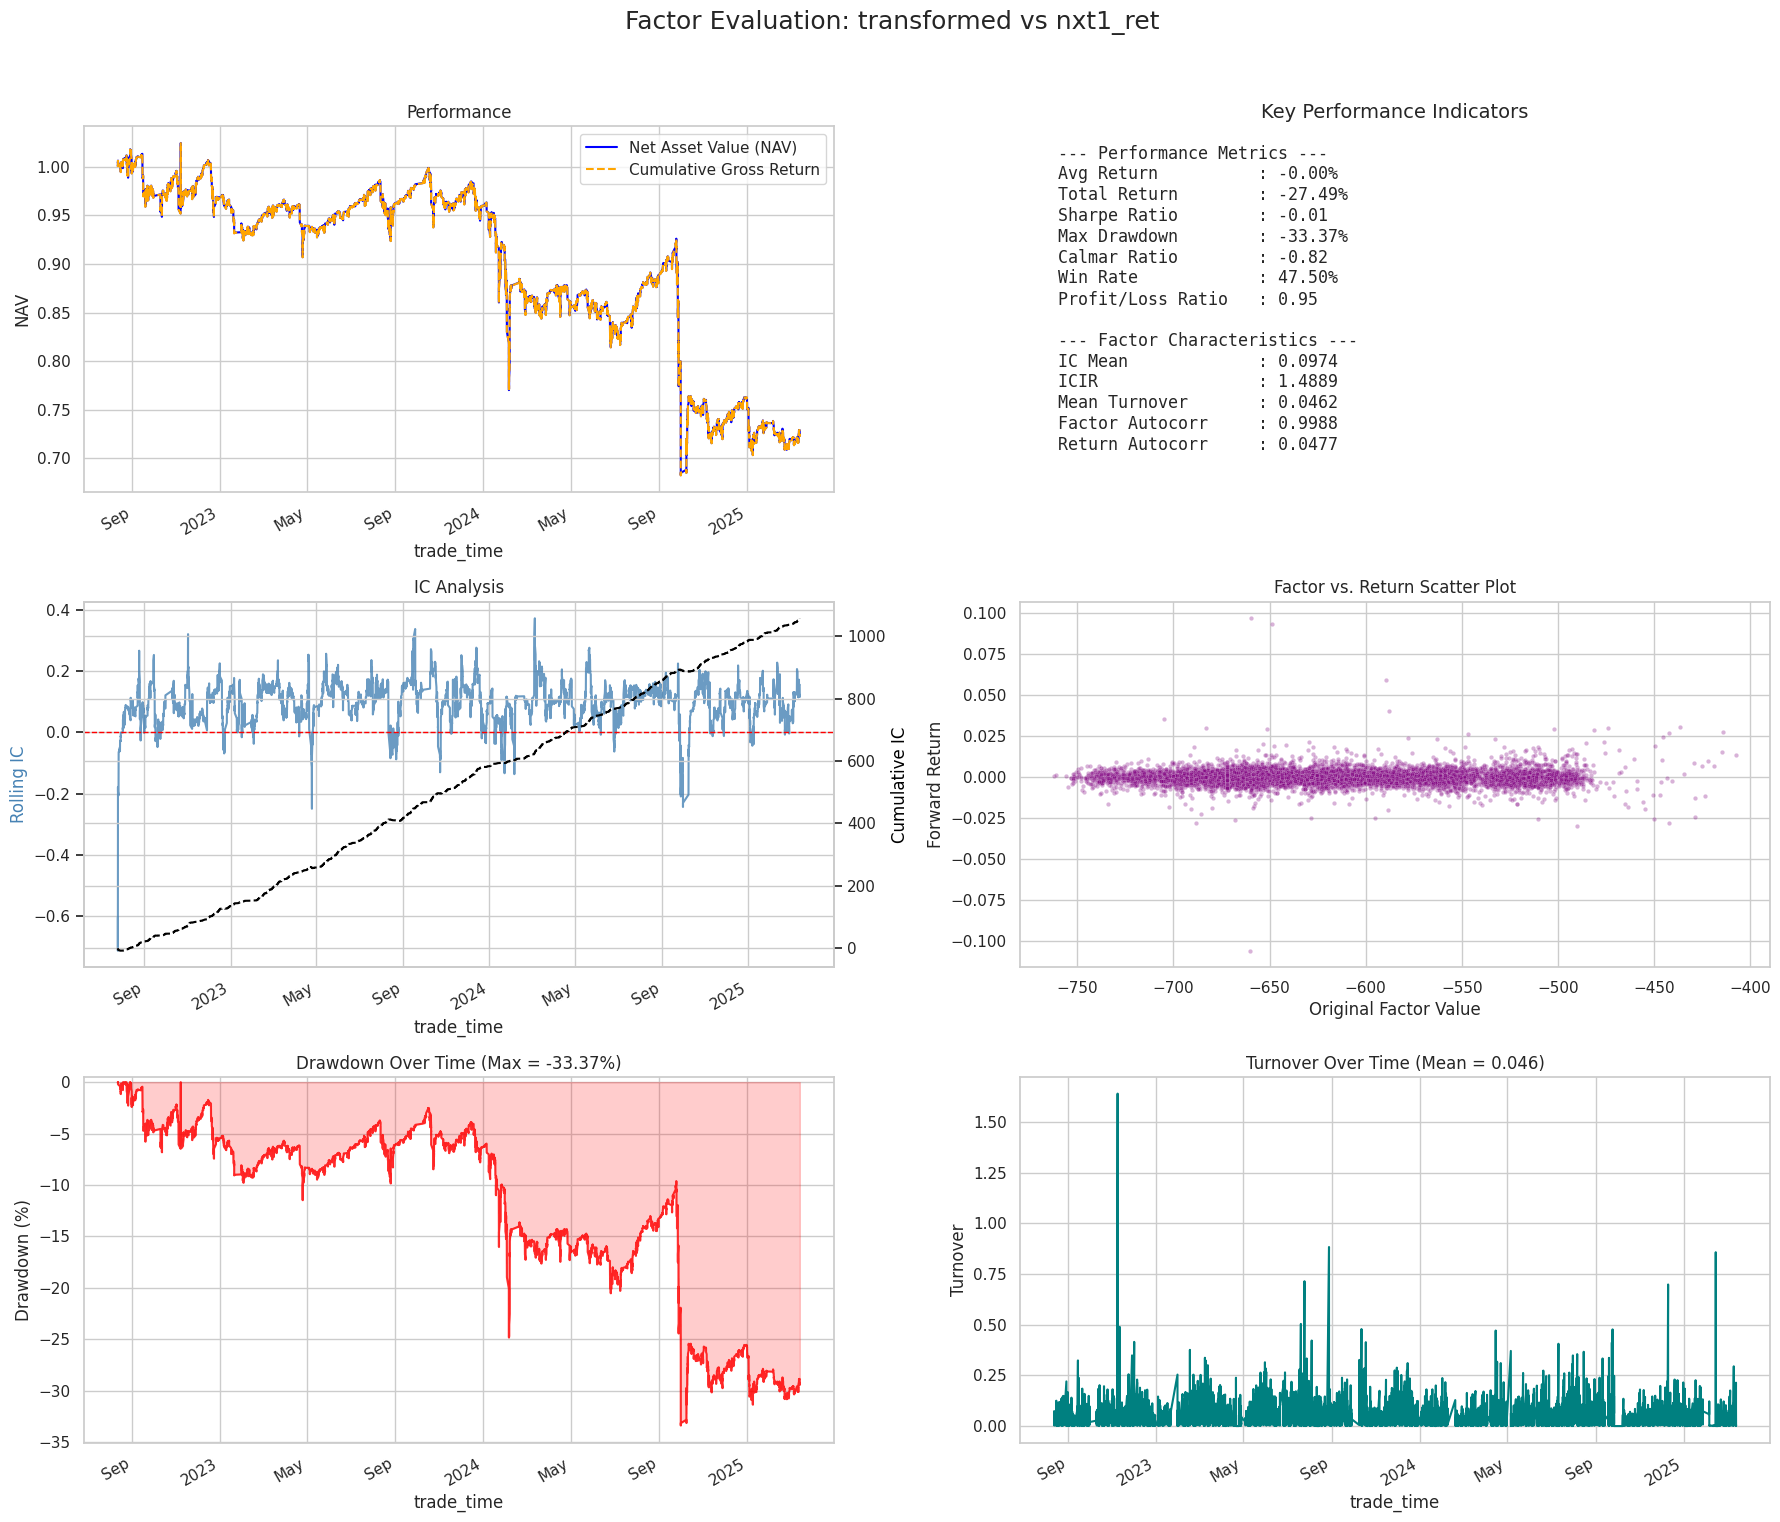

In [50]:
evaluate1.plot_results()

In [25]:
data1['transformed'].autocorr(lag=1)

0.9826486050228703